In [4]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import pearson_correlation as ps
import pre_processing as pre
import graphic as gr
import download_file as dl
from pca import pca 
import matplotlib.pyplot as plt  
from statsmodels.graphics.gofplots import qqplot 
plt.rcParams["figure.figsize"] =(22,15)

In [5]:
#----------------------------------------READ-DATA-----------------------------------------------------
first_column = ['Time','VCPM']
columns = [first_column[x] if x<2 else f'Vi{x}' for x in range(16386)] 
data = dl.read_file('DATASET03.csv',url='http://ltu.diva-portal.org/smash/get/diva2:1244889',separator=',',columns=columns) 
 
#----------------------------------------READ-DATA-----------------------------------------------------
 

In [6]:
data.head(5000)

,Time,VCPM,Vi2,Vi3,Vi4,Vi5,Vi6,Vi7,Vi8,Vi9,...,Vi16376,Vi16377,Vi16378,Vi16379,Vi16380,Vi16381,Vi16382,Vi16383,Vi16384,Vi16385
0,0.000000,1100.2980,-1.322455,-1.444341,1.373952,0.257178,0.734968,0.729179,-1.732295,0.448538,...,1.174365,1.410213,1.750882,1.000069,0.110916,-0.950096,-1.225861,-1.697253,-1.214282,-1.212149
1,0.000915,910.2272,-0.937603,-0.350420,0.123714,-1.080818,0.806271,0.311722,-0.350420,0.527459,...,0.914140,0.681643,-0.353772,-0.122190,0.234934,0.866300,0.008227,-0.080444,0.392471,1.193257
2,0.001825,874.5125,0.398565,0.712419,-1.090873,0.011579,1.110984,-0.285516,-0.474134,0.283993,...,0.424161,0.260225,-0.510395,-0.047535,0.750813,-0.699317,-0.441834,0.963808,0.288868,-0.929071
3,0.005484,860.4854,0.990318,-1.895316,0.384853,1.577805,-0.350725,-0.268452,-0.405269,-0.400088,...,0.321168,-0.254436,0.062771,0.111525,-0.445795,-0.155099,0.028034,-0.081054,-0.450671,-0.532639
4,0.005596,1101.7020,-0.184656,0.312636,1.250848,-1.128048,-2.019030,-0.529287,2.424603,0.521060,...,-0.710286,1.241402,0.791340,-3.423758,0.075264,2.087590,-0.337013,-0.570118,2.378287,1.534840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000,3.841245,825.1778,-0.579565,-1.283452,-1.743874,-1.816700,-1.812739,-1.817919,-1.707003,-1.288937,...,0.412886,-0.127065,-0.369008,-0.390033,0.408316,1.169489,1.138409,0.427817,-0.110611,-0.419895
3001,3.842614,817.0729,0.458289,0.429036,0.509176,0.746547,0.532334,0.342802,-0.139559,0.648125,...,-0.274242,-0.298010,-0.269671,-0.438482,-0.423247,-0.323910,-0.159060,0.114572,-0.036566,-0.072217
3002,3.843986,842.4385,0.084710,0.045707,0.202025,0.169421,-0.306237,-0.864167,-1.203312,-0.704497,...,0.022244,0.359562,0.904998,0.959542,0.683472,0.303799,-0.115486,0.218479,0.592972,0.435740
3003,3.845354,861.4158,1.778002,0.227925,-1.461709,-2.545879,-2.229282,-1.408384,-0.754165,-0.357429,...,-0.060638,1.270654,2.212523,2.610783,2.053462,1.290460,-0.131027,-1.510463,-1.661906,-1.089654


In [7]:
segment_signal = data.iloc[:,2:]
new_signal = segment_signal.iloc[:,:12800]
#Determine variables  
print(new_signal.shape) 
N = len(new_signal.columns)*len(new_signal)#length of the array
Fs = 12800 	#sample rate (Hz)
T = 1/Fs;
print("# Samples:",N)


(3005, 12800)
# Samples: 38464000


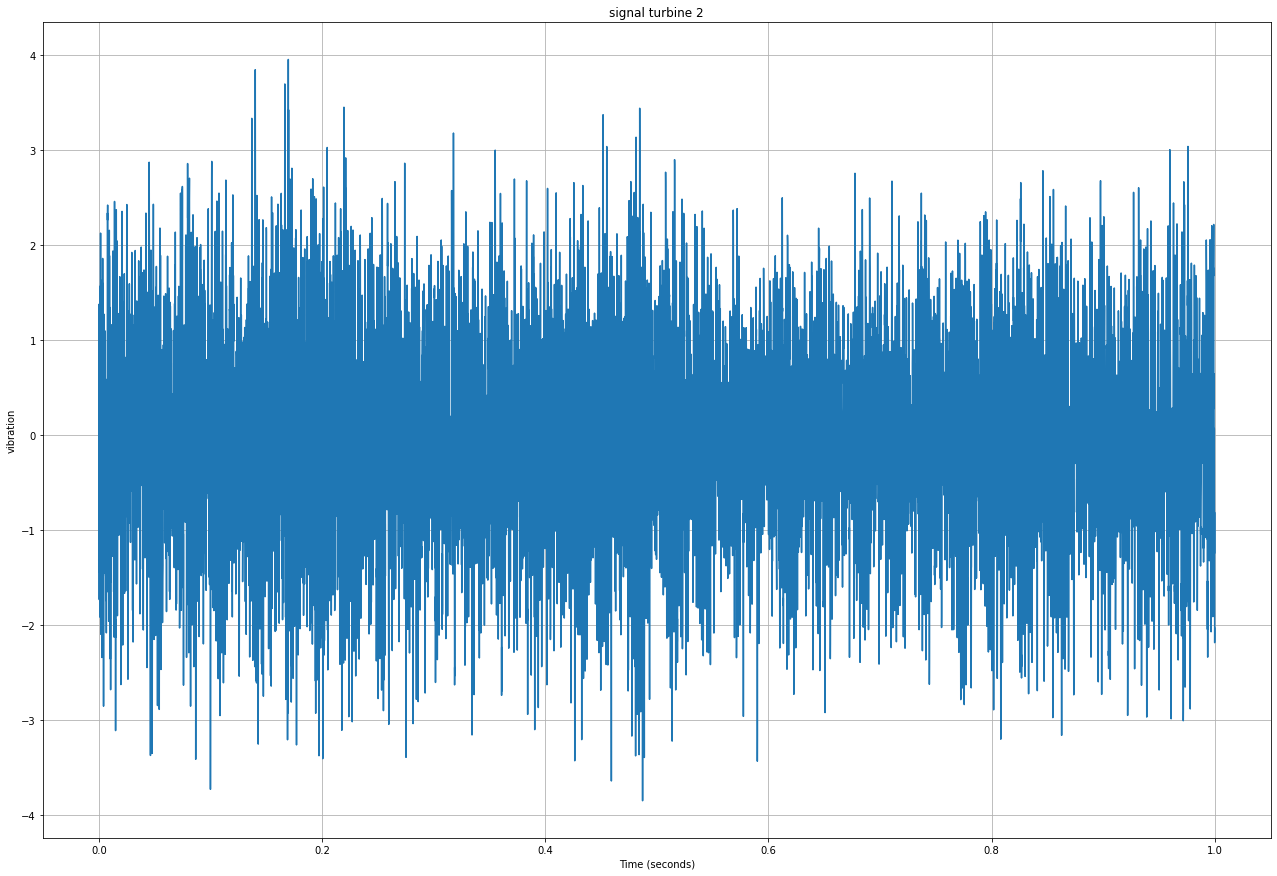

In [8]:

#Plot Data
time = [7.8125e-05*x for x in range(len(new_signal.iloc[0,:12800]))] 
plt.figure(1)  
plt.plot(time, new_signal.iloc[0,:12800])
plt.xlabel('Time (seconds)')
plt.ylabel('vibration')
plt.title('signal turbine 2')
plt.grid()  
plt.show()  
time = [7.8125e-05*x*(t+1) for t in range(len(new_signal)) for x in range(len(new_signal.iloc[t,:12800]))] 

In [9]:
1.50238262e+03

1502.38262

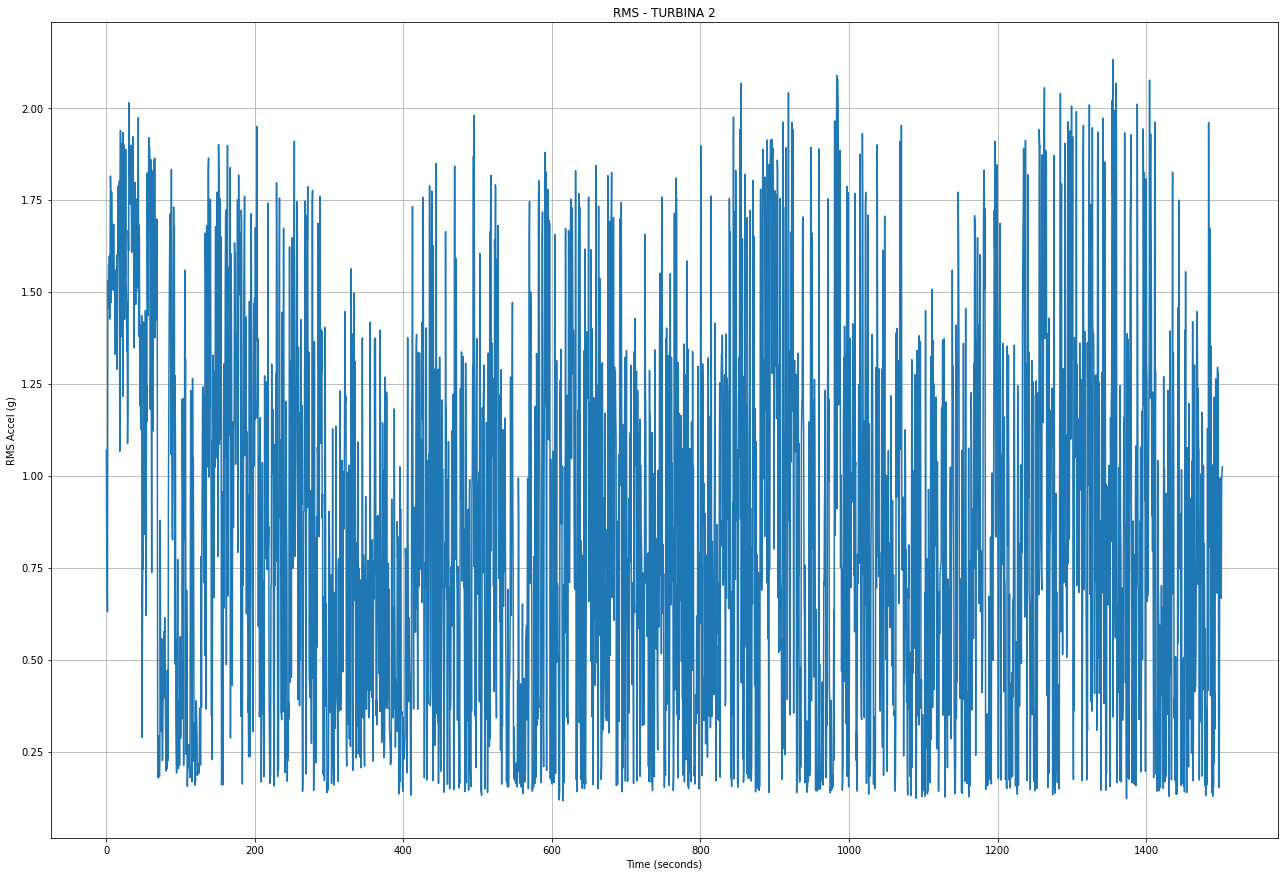

In [10]:

w = np.int(np.floor(Fs)); #width of the window for computing RMS
steps =  np.int_(np.floor(N/w)); #Number of steps for RMS
t_RMS = np.zeros((steps,1)); #Create array for RMS time values
x_RMS = np.zeros((steps,1)); #Create array for RMS values  
for i in range (0, steps):
    t_RMS[i] = np.mean(time[(i*w):((i+1)*w)])
    x_RMS[i] = np.sqrt(np.mean(new_signal.iloc[i,:]**2))   
 
plt.figure(2)  
plt.plot(t_RMS, x_RMS)
plt.xlabel('Time (seconds)')
plt.ylabel('RMS Accel (g)')
plt.title('RMS - TURBINA 2')
plt.grid()  

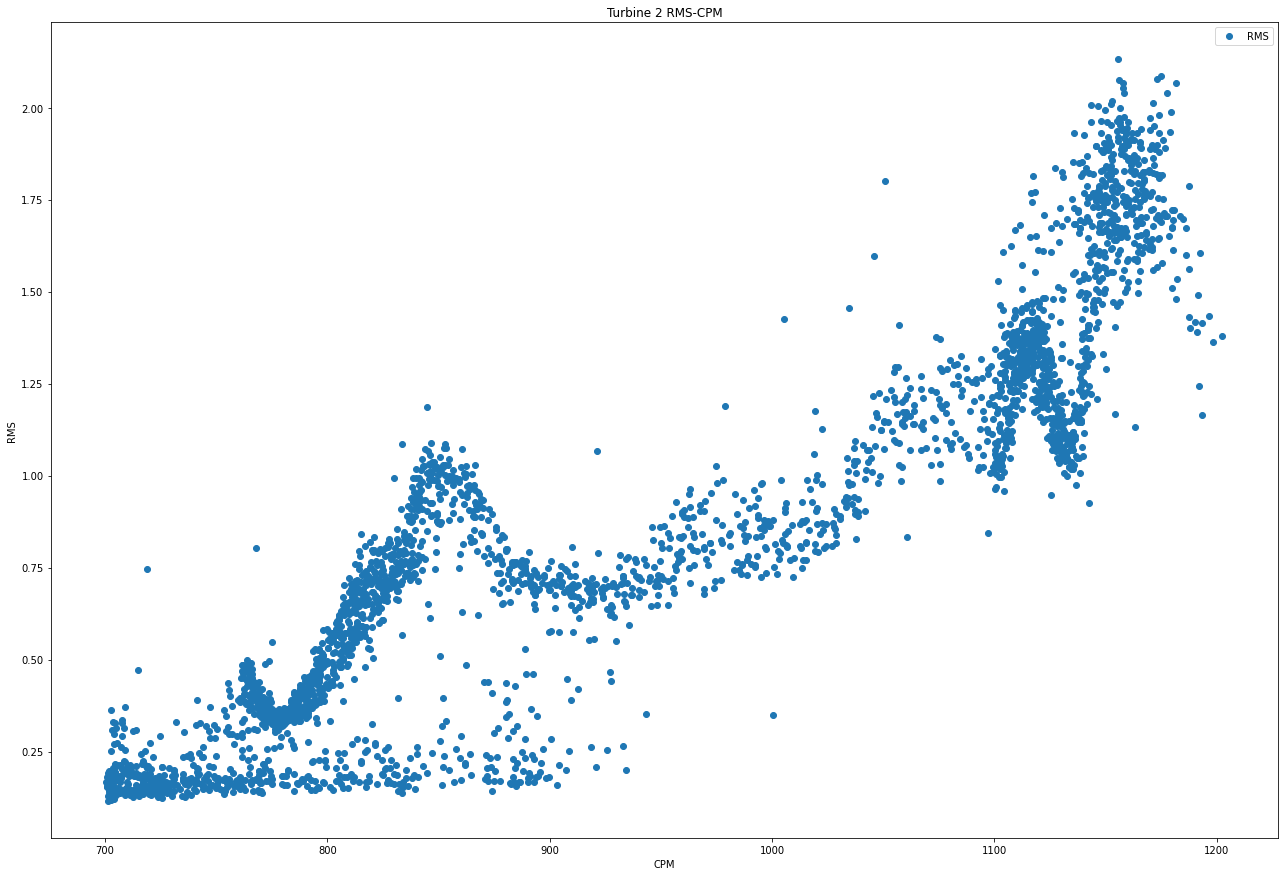

In [11]:
 

cpm = data.iloc[:,1:2]
len(cpm)
#scatter plot x - column 0, y - column 1, shown with marker o
plt.plot(cpm,x_RMS, 'o', label = 'RMS')
#create legend in case you have more than one series
plt.legend() 
plt.title('Turbine 2 RMS-CPM')
plt.xlabel('CPM')
plt.ylabel('RMS')
plt.show()

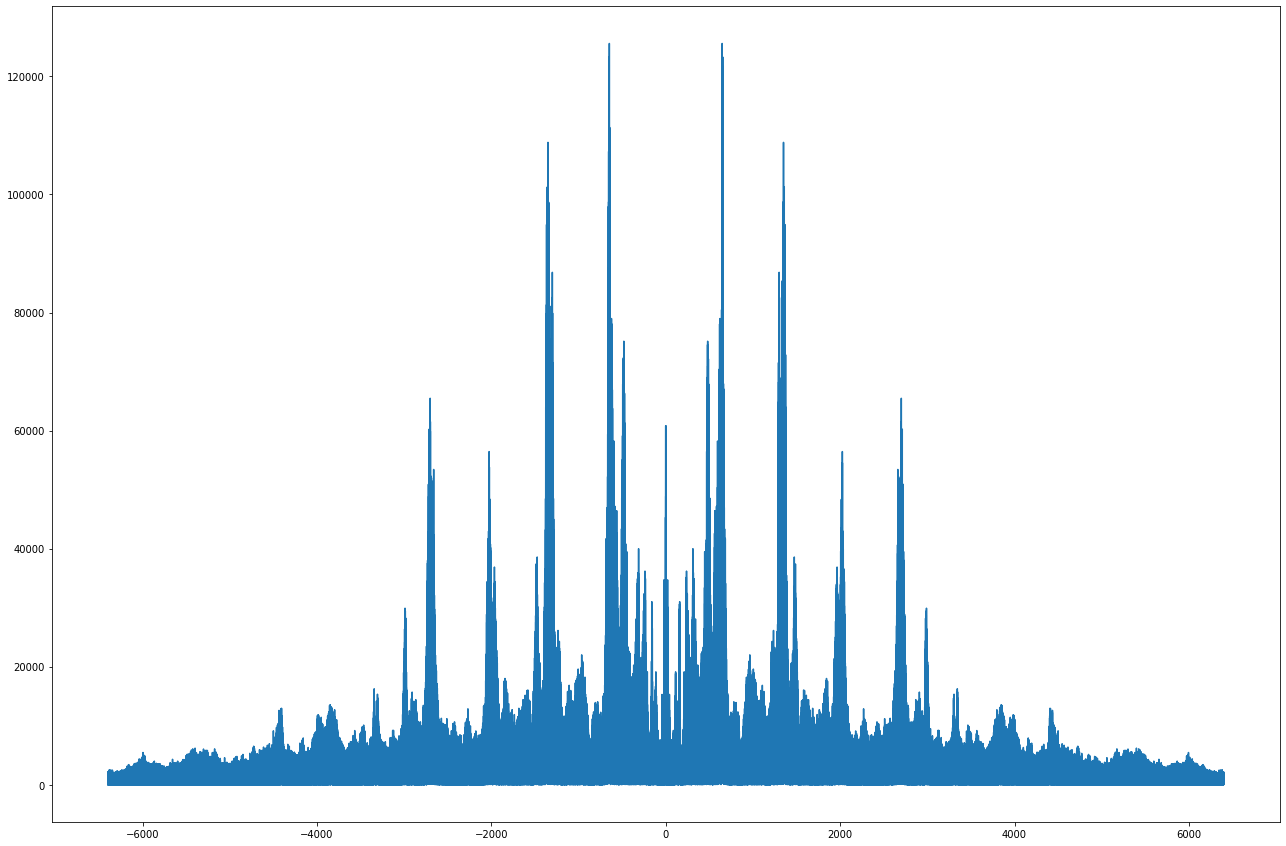

In [20]:
signal_for_day =[]
for i in range (0, 3005):
    signal_for_day.append(new_signal.iloc[i,:])
from scipy.fft import fft, fftfreq

# Number of samples in normalized_tone
N = 12800 * 3005

yf = fft(new_signal.values.flatten())
xf = fftfreq(N, 1 / 12800)

plt.plot(xf, np.abs(yf))
plt.show()


In [21]:
new_signal.values.flatten()

array([-1.32245531, -1.44434059,  1.37395184, ..., -0.95192405,
       -0.37327368, -0.08257728])

In [49]:
(3005/2)

1502.5

In [50]:
1502.5/365

4.116438356164384

In [51]:
5000*16384

81920000

In [52]:
for row in range(len(data)):
   print(f' row {row} {data.iloc[row,2:].mean()}')

392522261
 row 2389 0.0004603058973984206
 row 2390 0.0005228703030084802
 row 2391 1.2832770472901572e-05
 row 2392 0.00037501446929866233
 row 2393 3.507623929265187e-05
 row 2394 0.0003581644837211606
 row 2395 0.0004592643971861295
 row 2396 0.0002537912838747134
 row 2397 0.00047935047270896564
 row 2398 0.0004813590802612536
 row 2399 0.00011902859569095509
 row 2400 0.0002025345948553168
 row 2401 0.00010087673484804305
 row 2402 0.00018631694869242904
 row 2403 0.000344550588089014
 row 2404 0.00030768891986097946
 row 2405 0.0005865877981392625
 row 2406 0.000266289286422243
 row 2407 0.0001658589088080456
 row 2408 7.443006874297063e-05
 row 2409 0.00016898340944496507
 row 2410 0.00013576699195995585
 row 2411 0.00025460960547006844
 row 2412 0.0002687070547722258
 row 2413 0.00014357824355214904
 row 2414 7.83356945391056e-05
 row 2415 0.00032684508447999687
 row 2416 8.525423166361092e-05
 row 2417 0.00021309838272289688
 row 2418 0.0004679683632460448
 row 2419 0.00012051

In [53]:
data.std()

Time         1.150467
VCPM       158.985649
Vi2          0.960748
Vi3          0.987841
Vi4          1.004685
              ...    
Vi16381      1.000574
Vi16382      1.017269
Vi16383      0.995093
Vi16384      0.992769
Vi16385      0.994033
Length: 16386, dtype: float64

In [54]:

#----------------------------------------PEARSON-----------------------------------------------------
pearson_matrix = ps.pearson_correlation(wind_turbine)  
result = ps.transform_value(pearson_matrix)
result=result.astype(float)
display(pearson_matrix)
#gr.seaborn_pearson_plot(result)  
#----------------------------------------PEARSON-----------------------------------------------------

NameError: name 'wind_turbine' is not defined

In [ ]:

#-----------------------------------FILLNaNVALUES AND SELECT TARGET----------------------------------
wind_turbine = pre.fill_NaN_values(wind_turbine.copy())
y_train_old =pre.select_y(wind_turbine)
wind_turbine = wind_turbine.drop('Rbt_avg',axis=1)   

#-----------------------------------FILLNaNVALUES AND SELECT TARGET----------------------------------
